# Fine Mapping

I want to take the significant eQTL variants and functionally annotate them
to try to determine which variants might be causal.

I'd like to annotate the variants with various functional annotations. I'd also
like to search for TF motif disruptions and perhaps use phasing information
and allelic bias.

In [1]:
import cPickle
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
import seaborn as sns
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    pbt.set_tempdir('/frazer01/home/cdeboever/tmp')
    
outdir = os.path.join(ciepy.root, 'output',
                      'fine_mapping')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'fine_mapping')
cpy.makedir(private_outdir)

In [2]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
qvalues.columns = ['{}_gene'.format(x) for x in qvalues.columns]
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'most_sig_single.tsv')
most_sig = pd.read_table(fn, index_col=0)
most_sig['variant'] = (most_sig.chrom + ':' + most_sig.start.astype(str) + 
                       '-' + most_sig.end.astype(str))
most_sig['gene'] = most_sig.index

genes = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'gene_variant_pairs.tsv')
sig_variants = pd.read_table(fn)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
encode_chip_seq = pd.read_table(fn, index_col=0)

ensg = pd.Series(gene_info.index, index=[x.split('.')[0] for x in gene_info.index])

In [3]:
# ASE results.
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

I'll convert the significant variants to have one-based coordinates and add
a unique variant name. I'm going to drop CNVs because they likely act through 
different mechanisms than what I am looking at here.

In [4]:
sig_variants['beg'] = sig_variants.beg - 1
sig_variants['variant'] = (sig_variants.chrom + ':' + sig_variants.beg.astype(str) + 
                           '-' + sig_variants.end.astype(str))
sig_variants.index = sig_variants.variant + ':' + sig_variants.gene

In [5]:
ind = (most_sig.chrom + ':' + most_sig.start.astype(str) + '-' +
       most_sig.end.astype(str) + ':' + pd.Series(most_sig.index, index=most_sig.index))
most_sig.index = ind

s = set(most_sig.index) & set(sig_variants.index)
sig_variants['most_sig_variant'] = False
sig_variants.ix[s, 'most_sig_variant'] = True

## Predicted NMD

I'll use the snpEff annotation of the WGS to look for predicted NMD. I'd like to
see if any of the significant variants are predicted to cause NMD for the eQTL
gene.

If snpEff predicts NMD for a gene, the annotation looks like

    PITRM1|ENSG00000107959|11|0.27
    
This means that PITRM1 has 11 transcripts and 27% of them are predicted to have NMD.

In [6]:
fns = glob.glob('/projects/CARDIPS/pipeline/WGS/mergedVCF/annotation/vcf/*snpeff.vcf.gz')
fns = [x for x in fns if len(re.findall('chr\d{1,2}', x)) > 0]
fns = pd.Series(fns, index=[re.findall('chr\d{1,2}', x)[0] for x in fns])

for vcf in fns.values:
    out = os.path.join(private_outdir, os.path.split(vcf)[1].replace('.vcf.gz', '_nmd.vcf'))
    if not os.path.exists(out):
        !zcat {vcf} | java -jar /software/snpEff_v4_1l_core/SnpSift.jar filter "NMD[*]" > {out}

In [7]:
fns = glob.glob(os.path.join(private_outdir, '*_nmd.vcf'))
variants = []
nmd = []
for fn in fns:
    vcf_reader = pyvcf.Reader(open(fn))
    for r in vcf_reader:
        variants.append('chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS))
        nmd.append(r.INFO['NMD'])
ind = []
vals = []
for i, v in enumerate(variants):
    r = nmd[i]
    for n in r:
        gene_name, gene_id, num_t, per_t = n.strip(')').split('|')
        ind.append(v + ':' + ensg[gene_id])
        vals.append([int(num_t), float(per_t)])
nmd = pd.DataFrame(vals, index=ind, columns=['nmd_num_transcripts', 'nmd_percent_transcripts_nmd'])

In [8]:
sig_variants['variant_gene'] = (sig_variants.chrom + ':' + sig_variants.beg.astype(str) + 
                                '-' + sig_variants.end.astype(str) + ':' + sig_variants.gene)

In [9]:
sig_variants = sig_variants.merge(nmd, left_on='variant_gene', right_index=True, how='left')

In [10]:
sig_variants['nmd'] = False
sig_variants.ix[sig_variants.dropna(subset=['nmd_num_transcripts']).index, 'nmd'] = True

In [11]:
sig_variants.nmd.value_counts()

False    525824
True         11
Name: nmd, dtype: int64

In [12]:
g = set(sig_variants.ix[sig_variants.nmd, 'gene'])
df = pd.DataFrame(True, index=g, columns=['gene_has_nmd_variant'])
sig_variants = sig_variants.merge(df, left_on='gene', right_index=True, how='left')
sig_variants.ix[sig_variants.gene_has_nmd_variant.isnull(), 'gene_has_nmd_variant'] = False

## Exons, UTRs, and Promoters

I'll annotate whether variants fall in exons, UTRs or promoters for their significant
genes.

In [13]:
sig_variants_bt = pbt.BedTool('\n'.join(set(sig_variants.apply(lambda x: '{}\t{}\t{}'.format(
                    x['chrom'], x['beg'], x['end']), axis=1))), from_string=True)
sig_variants_bt = sig_variants_bt.sort()

In [14]:
exons = pbt.BedTool(cpy.gencode_exon_bed)
utrs = pbt.BedTool(cpy.gencode_utr_bed)
promoters = pbt.BedTool(cpy.gencode_promoter_bed)

In [15]:
res = sig_variants_bt.intersect(exons, wo=True, sorted=True)
df = res.to_dataframe()

In [16]:
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')

In [17]:
res = sig_variants_bt.intersect(exons, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
sig_variants['exonic_same_gene'] = False
sig_variants.ix[set(df.val) & set(sig_variants.index), 'exonic_same_gene'] = True

df['exonic'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
sig_variants = sig_variants.merge(df[['exonic']], left_on='variant', right_index=True, how='left')
sig_variants.ix[sig_variants.exonic.isnull(), 'exonic'] = False

In [18]:
g = set(sig_variants.ix[sig_variants.exonic, 'gene'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_variant'])
sig_variants = sig_variants.merge(df, left_on='gene', right_index=True, how='left')
sig_variants.ix[sig_variants.gene_has_exonic_variant.isnull(), 'gene_has_exonic_variant'] = False

g = set(sig_variants.ix[sig_variants.exonic_same_gene, 'gene'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_same_gene_variant'])
sig_variants = sig_variants.merge(df, left_on='gene', right_index=True, how='left')
sig_variants.ix[sig_variants.gene_has_exonic_same_gene_variant.isnull(), 'gene_has_exonic_same_gene_variant'] = False

In [19]:
res = sig_variants_bt.intersect(utrs, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
sig_variants['utr_same_gene'] = False
sig_variants.ix[set(df.val) & set(sig_variants.index), 'utr_same_gene'] = True

df['utr'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
sig_variants = sig_variants.merge(df[['utr']], left_on='variant', right_index=True, how='left')
sig_variants.ix[sig_variants.utr.isnull(), 'utr'] = False

In [20]:
res = sig_variants_bt.intersect(promoters, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart.apply(lambda x: x.split('_')[0])].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
sig_variants['promoter_same_gene'] = False
sig_variants.ix[set(df.val) & set(sig_variants.index), 'promoter_same_gene'] = True

df['promoter'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
sig_variants = sig_variants.merge(df[['promoter']], left_on='variant', right_index=True, how='left')
sig_variants.ix[sig_variants.promoter.isnull(), 'promoter'] = False

In [21]:
g = set(sig_variants.ix[sig_variants.utr, 'gene'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_variant'])
sig_variants = sig_variants.merge(df, left_on='gene', right_index=True, how='left')
sig_variants.ix[sig_variants.gene_has_utr_variant.isnull(), 'gene_has_utr_variant'] = False

g = set(sig_variants.ix[sig_variants.utr_same_gene, 'gene'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_same_gene_variant'])
sig_variants = sig_variants.merge(df, left_on='gene', right_index=True, how='left')
sig_variants.ix[sig_variants.gene_has_utr_same_gene_variant.isnull(), 
                'gene_has_utr_same_gene_variant'] = False

g = set(sig_variants.ix[sig_variants.promoter_same_gene, 'gene'])
df = pd.DataFrame(True, index=g, columns=['gene_has_promoter_same_gene_variant'])
sig_variants = sig_variants.merge(df, left_on='gene', right_index=True, how='left')
sig_variants.ix[sig_variants.gene_has_promoter_same_gene_variant.isnull(), 
                'gene_has_promoter_same_gene_variant'] = False

## TSS Distance

I want to find the distance from each variant to the nearest TSS of the
gene that the variant is significant for. Some variants are significant
for multiple genes but will be closest to the TSS for only one gene. I'm going
to construct "fake" bed file with gene IDs as chromosome names. This will
allow me to compare all of the significant variants for a gene to that gene's
TSSs.

In [22]:
tss = pbt.BedTool(cpy.gencode_tss_bed)
tss_df = tss.to_dataframe()
tss_df['gene'] = tss_df.name.apply(lambda x: transcript_to_gene[x.split('_')[0]])
s = '\n'.join(tss_df.gene + '\t' + tss_df.start.astype(str) + '\t' +
              tss_df.end.astype(str) + '\t' + tss_df.name + '\t' + 
              tss_df.score + '\t' + tss_df.strand) + '\n'
fake_tss = pbt.BedTool(s, from_string=True)
fake_tss = fake_tss.sort()

s = '\n'.join(sig_variants.gene + '\t' + sig_variants.beg.astype(str) + '\t' + 
              sig_variants.end.astype(str) + '\t.\t' + sig_variants.chrom) + '\n'
fake_sig_variants_bt = pbt.BedTool(s, from_string=True)
fake_sig_variants_bt = fake_sig_variants_bt.sort()

res = fake_sig_variants_bt.closest(fake_tss, D='b', sorted=True)
res_df = res.to_dataframe()
res_df.index = (res_df.score + ':' + res_df.start.astype(str) + '-' + 
                res_df.end.astype(str) + ':' + res_df.chrom)
res_df['variant_gene'] = res_df.index
res_df = res_df.drop_duplicates(subset=['variant_gene'])
sig_variants['tss_dist'] = res_df.ix[sig_variants.index, 'blockStarts']
sig_variants['tss_dist_abs'] = sig_variants.tss_dist.abs()

## Maurano et al. 2015 Data

I'm going to grab some data from [Maurano *et al.* 2015](http://www.nature.com/ng/journal/v47/n12/full/ng.3432.html).
The zip file seems to be corrupted. I was able to manually download on my mac 
and decompress it using Arhcive Utility but I couldn't get it work from the
command line so that this has to be downloaded by hand.

In [23]:
# This has all of the variants tested for imbalance and their significance.
maurano_res = pd.read_table('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S5.txt')
# This has SNVs from dbSNP 138 predicted to affect TF binding.
fn = os.path.join(private_outdir, 'ng.3432-S7')
if not os.path.exists(fn):
    print('Download ng.3432-S7, decompress, and add to private_outdir.')
    print('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S7.zip')
else:
    maurano_tf_disrupt = pd.read_table(fn)

In [24]:
se = maurano_res.chromEnd - maurano_res.chromStart
se[se > 1].shape

(0,)

The Maurano results are all SNVs.

In [25]:
print(len(set(maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + '-' + 
              maurano_res.chromEnd.astype(str))))
print(maurano_res.shape[0])

362284
362284


In [26]:
maurano_res.index = (maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + 
                     '-' + maurano_res.chromEnd.astype(str))

The Maurano results are all unique variants.

In [27]:
maurano_res.head(1)

,chrom,chromStart,chromEnd,rs,numhets,allele.1,readsA,allele.2,readsB,totalReads,pctRef,q.value,significance.level
chr1:752720-752721,chr1,752720,752721,snp5,33,G,1583,A,1454,3037,0.479,0.0912,not_imbalanced


It seems that the Maurano data is in zero-based coordinates.

In [28]:
maurano_res.columns = ['{}_maurano'.format(c) for c in maurano_res.columns]
sig_variants = sig_variants.merge(maurano_res, left_on='variant', right_index=True, how='left')
sig_variants = sig_variants.drop(['chrom_maurano', 'chromStart_maurano', 'chromEnd_maurano'], axis=1)

I'll also add in the predicted TF disruptions.

In [29]:
maurano_tf_disrupt.columns = ['{}_maurano_tf'.format(x) for x in maurano_tf_disrupt.columns]
maurano_tf_disrupt.index = (maurano_tf_disrupt.chrom_maurano_tf + ':' +
                            maurano_tf_disrupt.snpChromStart_maurano_tf.astype(str) + 
                            '-' + maurano_tf_disrupt.snpChromEnd_maurano_tf.astype(str))
sig_variants = sig_variants.merge(maurano_tf_disrupt, left_on='variant', 
                                  right_index=True, how='left')

In [30]:
sig_variants = sig_variants.drop(['chrom_maurano_tf', 'snpChromStart_maurano_tf', 
                                  'snpChromEnd_maurano_tf'], axis=1)

## Roadmap DNase

In [31]:
out = os.path.join(outdir, 'roadmap_dnase.tsv')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
             'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
             'H9 Cell Line']
    urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

    df = pd.DataFrame(False, index=set(sig_variants.variant), columns=lines)
    for url in urls:
        line = roadmap_ids[os.path.split(url)[1].split('-')[0]]
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True).sort()
        res = sig_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values, line] = True
    df = df.ix[:, df.sum() > 0]
    df.columns = [c.replace(' Cell Line', '').replace(' ', '_') + '_roadmap_dnase' for c in df.columns]
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

sig_variants = sig_variants.merge(df, left_on='variant', right_index=True, how='left')

## ENCODE DNase

In [32]:
out = os.path.join(outdir, 'encode_dnase.tsv')
if not os.path.exists(out):
    encode_dnase = pd.read_table(os.path.join(ciepy.root, 'output', 
                                              'functional_annotation_analysis', 
                                              'encode_dnase.tsv'), index_col=0)
    bs_types = ['stem cell', 'induced pluripotent stem cell line']
    encode_dnase = encode_dnase[encode_dnase.biosample_type.apply(lambda x: x in bs_types)]

    cols = (encode_dnase.cell_type.apply(lambda x: x.replace('induced pluripotent stem cell', 'iPSC')) + 
            '_' + encode_dnase.index + '_dnase')
    df = pd.DataFrame(False, index=set(sig_variants.variant), columns=cols)
    encode_dnase['col'] = cols
    for i in encode_dnase.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_dnase.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = sig_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_dnase.ix[i, 'col']] = True
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

sig_variants = sig_variants.merge(df, left_on='variant', right_index=True, how='left')

## ENCODE Transcription Factor ChIP-Seq

In [33]:
out = os.path.join(outdir, 'encode_tf_chip_seq.tsv')
if not os.path.exists(out):
    encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                    'functional_annotation_analysis', 
                                                    'encode_stem_cell_chip_seq.tsv'), index_col=0)
    encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')


    cols = encode_tf_chip_seq.target + '_tf_chip'
    df = pd.DataFrame(False, index=set(sig_variants.variant), columns=cols)
    encode_tf_chip_seq['col'] = cols
    for i in encode_tf_chip_seq.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_tf_chip_seq.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = sig_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_tf_chip_seq.ix[i, 'col']] = True

    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

sig_variants = sig_variants.merge(df, left_on='variant', right_index=True, how='left')

## TF Motif Disruption

In [34]:
sig_variants['ref_allele'] = sig_variants.marker_id.apply(lambda x: x.split('/')[0].split('_')[-1])
sig_variants['alt_allele'] = sig_variants.marker_id.apply(lambda x: x.split('/')[1].split('_')[0])

In [35]:
out = os.path.join(outdir, 'tf_disruption.tsv')
if not os.path.exists(out):
    fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
    with open(fn) as f:
        matrices = cPickle.load(f)
    fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
    motif_info = pd.read_table(fn, index_col=0)
    fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
    motif_info_rep = pd.read_table(fn, index_col=0)

    tf_cols = [x for x in sig_variants.columns if 'tf_chip' in x]
    tdf = sig_variants[['variant', 'ref_allele', 'alt_allele'] + tf_cols]
    tdf = tdf.drop_duplicates()
    tdf.index = tdf.variant
    tdf = tdf.drop('variant', axis=1)
    tdf = tdf[tdf[tf_cols].sum(axis=1) > 0]
    tdf['tfs'] = tdf.apply(lambda x: set(motif_info.tf) & 
                           set([y.split('_')[0] for y in x[tf_cols][x[tf_cols]].index]), axis=1)
    tdf = tdf[tdf.tfs.apply(lambda x: len(x)) > 0]
    tdf = tdf.drop(tf_cols, axis=1)
    tdf['motif_names'] = tdf.tfs.apply(lambda x: list(motif_info[motif_info.tf.apply(lambda y: y in x)].index))
    
    from ipyparallel import Client
    parallel_client = Client()
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    dview.push(dict(tdf=tdf));
    dview.push(dict(matrices=matrices));
    
    res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
            i, tdf.ix[i, 'ref_allele'], tdf.ix[i, 'alt_allele'], cpy.hg19, 
            {k:matrices[k] for k in tdf.ix[i, 'motif_names']}), tdf.index)
    cols = motif_info[motif_info.tf.apply(lambda x: x in [x.split('_')[0] for x in tf_cols])].index
    motif_d = pd.DataFrame(index=tdf.index, columns=cols)
    a = []
    b = []
    for i,p in enumerate(tdf.index):
        if res[i].shape[0] > 0:
            a.append(p)
            b.append(res[i])
    d = dict(zip(a,b))
    p = pd.Panel(d)
    motif_d = p.ix[:, :, 'score_diff'].T
    motif_d.to_csv(out, sep='\t')
else:
    motif_d = pd.read_table(out, index_col=0)

For `motif_d`, the value is reference score minus alternate score. So a positive
value means the reference matched the motif better.

I'm not sure what score difference constitutes a disruption. Let's
take a look at the distribution of differences.

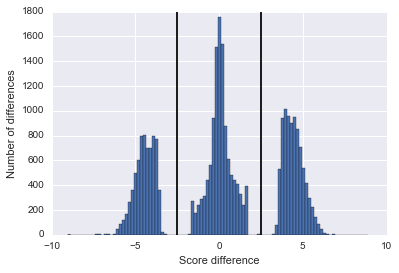

In [36]:
pd.Series(motif_d.values.flatten()).dropna().hist(bins=100)
ymin, ymax = plt.ylim()
plt.vlines(-2.5, ymin, ymax)
plt.vlines(2.5, ymin, ymax)
plt.ylabel('Number of differences')
plt.xlabel('Score difference');

It seems that a score difference greater than 2.5 in magnitude probably
represents a pretty big effect. I'll say these are disruptions.

In [37]:
motif_disrupt = motif_d.abs() >= 2.5
motif_disrupt.columns = ['{}_motif_disrupted'.format(x) for x in motif_disrupt.columns]
sig_variants = sig_variants.merge(motif_disrupt, left_on='variant', right_index=True, how='left')

In [38]:
tf_disrupt = motif_disrupt.copy(deep=True)
tf_disrupt.columns = ['{}_tf_disrupted'.format(x.split('_')[0]) for x in tf_disrupt.columns]
d = {}
for c in set(tf_disrupt.columns):
    t = tf_disrupt[c]
    if len(t.shape) > 1:
        d[c] = (tf_disrupt[c].sum(axis=1) == 1).values
    else:
        d[c] = t.values
tf_disrupt = pd.DataFrame(d, index=tf_disrupt.index)
sig_variants = sig_variants.merge(tf_disrupt, left_on='variant', right_index=True, how='left')

In [39]:
disrupted_cols = [x for x in sig_variants.columns if '_motif_disrupted' in x]
sig_variants['tf_disruption'] = sig_variants[disrupted_cols].sum(axis=1) > 0

## Phasing and ASE

Let's consider a putative eQTN. Let's assume that the direction of effect is such that
the homozygous alternative genotype has lowest expression. If we have the correct eQTN,
a subject who is het for the putative eQTN should see lower expression for the haplotype
that contains the alt variant. I can check this for SNVs given that our SNVs are phased.

## Feature Exploration

In [40]:
n = (sig_variants.gene.value_counts() > 1).value_counts()[False]
print('{:,} of {:,} genes have only one significant variant.'.format(n, len(set(sig_variants.gene))))

719 of 5,594 genes have only one significant variant.


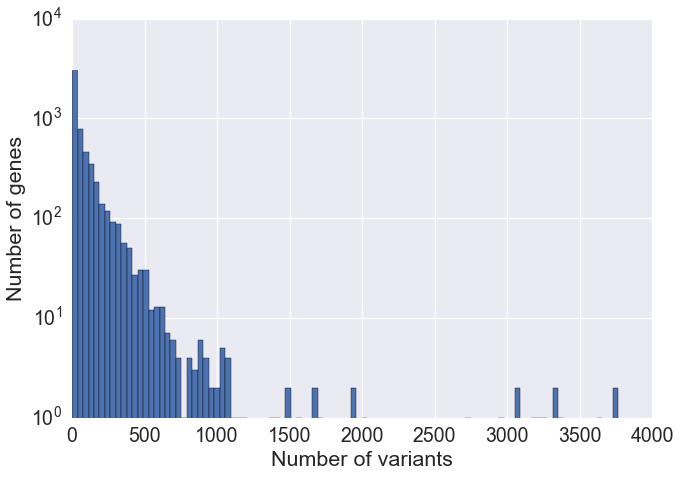

In [158]:
sig_variants.gene.value_counts().hist(bins=100, log=True)
plt.ylabel('Number of genes')
plt.xlabel('Number of variants');

In [42]:
gene_gb = sig_variants.groupby('gene')
num_genes = len(set(sig_variants.gene))

In [43]:
n = (gene_gb.exonic.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant exonic variant.'.format(
    n, num_genes))
m = (gene_gb.exonic_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own exon.'.format(
    m, n))

3,886 of 5,594 genes have at least one significant exonic variant.
2,894 of these 3,886 genes have at least one significant variant in their own exon.


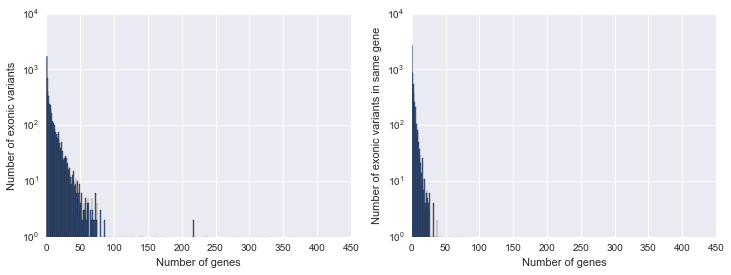

In [44]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.exonic.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[0])
ax.set_ylabel('Number of exonic variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.exonic_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[1])
ax.set_ylabel('Number of exonic variants in same gene')
ax.set_xlabel('Number of genes');

In [45]:
n = (gene_gb.utr.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant UTR variant.'.format(
    n, len(set(sig_variants.gene))))
m = (gene_gb.utr_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own UTR.'.format(
    m, n))

3,104 of 5,594 genes have at least one significant UTR variant.
1,987 of these 3,104 genes have at least one significant variant in their own UTR.


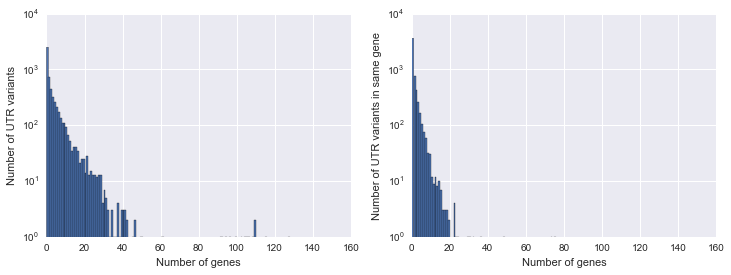

In [46]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.utr.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[0])
ax.set_ylabel('Number of UTR variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.utr_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[1])
ax.set_ylabel('Number of UTR variants in same gene')
ax.set_xlabel('Number of genes');

In [47]:
# ENCSR000EMU is probably the best ENCODE DNase to use.
for c in [x for x in sig_variants.columns if 'dnase' in x]:
    vc = sig_variants[c].value_counts()
    print('{}\t{:.2f}%'.format(c, float(vc[True]) / vc.sum()))

iPS_DF_6.9_roadmap_dnase	0.05%
iPS_DF_19.11_roadmap_dnase	0.05%
H1_roadmap_dnase	0.04%
H9_roadmap_dnase	0.05%
iPSC_ENCSR000EKK_dnase	0.04%
iPSC_ENCSR000EKJ_dnase	0.04%
iPSC_ENCSR000EKI_dnase	0.05%
iPSC_ENCSR000EKH_dnase	0.02%
H7-hESC_ENCSR000EMZ_dnase	0.02%
H1-hESC_ENCSR000EMU_dnase	0.01%
H9_ENCSR000EJP_dnase	0.02%
H7-hESC_ENCSR000EJO_dnase	0.07%
H1-hESC_ENCSR000EJN_dnase	0.06%


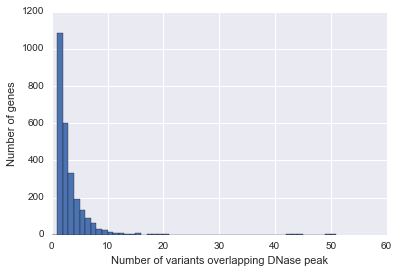

In [48]:
vc = sig_variants.ix[sig_variants['H1-hESC_ENCSR000EMU_dnase'] == True, 'gene'].value_counts()
vc.hist(bins=range(0, vc.max() + 1))
plt.ylabel('Number of genes')
plt.xlabel('Number of variants overlapping DNase peak');

In [49]:
sig_variants['significance.level_maurano'].value_counts()

not_imbalanced           26357
imbalanced_(5%_FDR)       5438
imbalanced_(0.1%_FDR)      591
Name: significance.level_maurano, dtype: int64

In [50]:
maurano_res['significance.level_maurano'].value_counts()

not_imbalanced           297687
imbalanced_(5%_FDR)       55141
imbalanced_(0.1%_FDR)      9456
Name: significance.level_maurano, dtype: int64

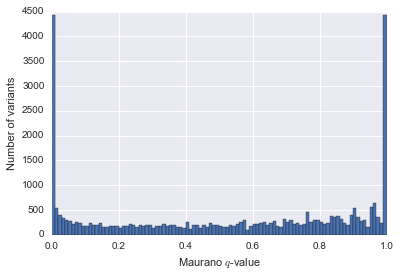

In [51]:
sig_variants['q.value_maurano'].hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $q$-value');

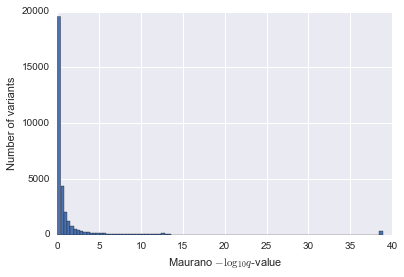

In [52]:
se = sig_variants['q.value_maurano'].dropna()
se += se[se > 0].min()
(-np.log10(se)).hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $-\log_{10}q$-value');

### Single variant genes

I'm going to look at genes for which there is only one significant
variant. In theory, these should often be the causal variants.

In [53]:
se = sig_variants.gene.value_counts() == 1
genes = set(se[se].index)
tdf = sig_variants[sig_variants.gene.apply(lambda x: x in genes)]

In [54]:
n = tdf.exonic.value_counts()[True]
print('{} of {} genes have an exonic variant.'.format(n, tdf.shape[0]))
n = tdf.utr.value_counts()[True]
print('{} of {} genes have a UTR variant.'.format(n, tdf.shape[0]))
n = tdf['H1-hESC_ENCSR000EMU_dnase'].value_counts()[True]
print('{} of {} genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.'.format(n, tdf.shape[0]))

100 of 719 genes have an exonic variant.
50 of 719 genes have a UTR variant.
33 of 719 genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.


In [55]:
maurano_res['significance.level_maurano'].value_counts() / maurano_res.shape[0]

not_imbalanced           0.821695
imbalanced_(5%_FDR)      0.152204
imbalanced_(0.1%_FDR)    0.026101
Name: significance.level_maurano, dtype: float64

In [56]:
sig_variants['significance.level_maurano'].value_counts() / sig_variants['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.813839
imbalanced_(5%_FDR)      0.167912
imbalanced_(0.1%_FDR)    0.018249
Name: significance.level_maurano, dtype: float64

In [57]:
tdf['significance.level_maurano'].value_counts() / tdf['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.804348
imbalanced_(5%_FDR)      0.184783
imbalanced_(0.1%_FDR)    0.010870
Name: significance.level_maurano, dtype: float64

In [58]:
t = sig_variants.sort_values(by=['gene', 'pvalue'])
t = t.drop_duplicates(subset='gene')

In [59]:
t['significance.level_maurano'].value_counts() / t['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.740480
imbalanced_(5%_FDR)      0.242595
imbalanced_(0.1%_FDR)    0.016925
Name: significance.level_maurano, dtype: float64

## Fine Mapping

[Wen et al. 2015](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005176) says 50% of cis-eQTLs are concentrated within 20kb of the TSS.

I'll start by removing genes that have significant variants in their exons or
UTRs or are predicted to undergo NMD.

In [60]:
sig_variants_f = sig_variants[(sig_variants.gene_has_nmd_variant == False)]
a = len(set(sig_variants_f.gene))
b = len(set(sig_variants.gene))
print('{:,} of {:,} genes don\'t have a significant NMD variant.'.format(a, b))

5,584 of 5,594 genes don't have a significant NMD variant.


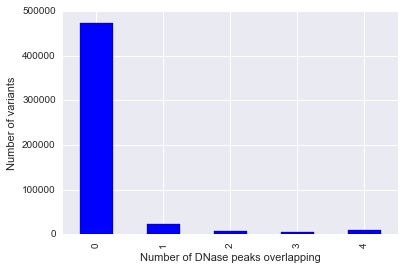

In [61]:
sig_variants_f['roadmap_dnase_num'] = \
    sig_variants_f[[x for x in sig_variants_f.columns 
                    if '_roadmap_dnase' in x]].sum(axis=1)

se = sig_variants_f.roadmap_dnase_num.value_counts()
se = se[range(se.shape[0])]
se.plot(kind='bar')
plt.ylabel('Number of variants')
plt.xlabel('Number of DNase peaks overlapping');

I'm going to keep variants that have some evidence of being functional.

In [62]:
a = len(set(sig_variants_f.gene))
sig_variants_f = sig_variants_f[
    (sig_variants_f.roadmap_dnase_num > 2) | 
    (sig_variants_f['significance.level_maurano'] == 'imbalanced_(5%_FDR)') | 
    (sig_variants_f['significance.level_maurano'] == 'imbalanced_(0.1%_FDR)') | 
    (sig_variants_f.tf_disruption)]
b = len(set(sig_variants_f.gene))
print('{:,} of {:,} genes have a putative causal variant.'.format(b, a))

3,634 of 5,584 genes have a putative causal variant.


I'm going to assign variants ranks based on whether

1. Overlaps 2 or more DNase peaks and significant in Maurano **or**
overlaps 2 or more DNase peaks and disrupts a TF
2. Disrupts a TF
3. Significant in Maurano
4. Everything else

I'll sort by this rank and then keep the variant closest to the TSS.

In [63]:
sig_variants_f['variant_rank'] = np.nan
a = sig_variants_f[
    (sig_variants_f.roadmap_dnase_num >= 2) & 
    ((sig_variants_f['significance.level_maurano'] == 'imbalanced_(0.1%_FDR)') |
     (sig_variants_f['significance.level_maurano'] == 'imbalanced_(5%_FDR)'))]
b = sig_variants_f[(sig_variants_f.roadmap_dnase_num >= 2) & 
                   (sig_variants_f.tf_disruption)]
t = pd.concat([a, b]).drop_duplicates()
sig_variants_f.ix[t.index, 'variant_rank'] = 1

sig_variants_f.ix[sig_variants_f.tf_disruption & 
                  sig_variants_f.variant_rank.isnull(), 'variant_rank'] = 2

sig_variants_f.ix[
    ((sig_variants_f['significance.level_maurano'] == 'imbalanced_(0.1%_FDR)') |
     (sig_variants_f['significance.level_maurano'] == 'imbalanced_(5%_FDR)')) &
    sig_variants_f.variant_rank.isnull(), 'variant_rank'] = 3

sig_variants_f.ix[sig_variants_f.variant_rank.isnull(), 'variant_rank'] = 4

In [64]:
sig_variants_f = sig_variants_f.sort_values(by=['variant_rank', 'tss_dist_abs'])
sig_variants_f = sig_variants_f.drop_duplicates(subset='gene')

In [65]:
sig_variants_f.tf_disruption.value_counts()

True     2393
False    1241
Name: tf_disruption, dtype: int64

In [175]:
n = sig_variants_f.shape[0] - sig_variants_f['significance.level_maurano'].value_counts().sum()
print('{:,} variants not measured in Maurano'.format(n))

1,784 variants not measured in Maurano


In [66]:
sig_variants_f['significance.level_maurano'].value_counts()

imbalanced_(5%_FDR)      1041
not_imbalanced            711
imbalanced_(0.1%_FDR)      98
Name: significance.level_maurano, dtype: int64

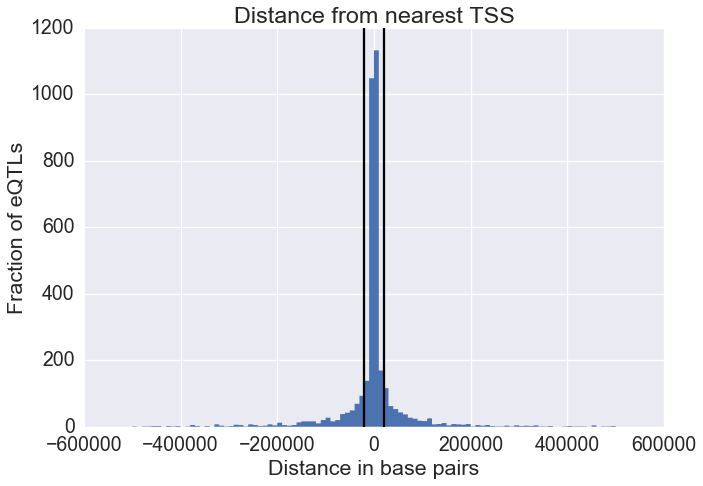

In [197]:
n,b,p = plt.hist(sig_variants_f.tss_dist, 
                 bins=np.arange(-500000, 510000, 10000),
                 histtype='stepfilled',
                 linewidth=0)
ymin, ymax = plt.ylim()
plt.vlines(-20000, ymin, ymax)
plt.vlines(20000, ymin, ymax)
plt.title('Distance from nearest TSS')
plt.ylabel('Fraction of eQTLs')
plt.xlabel('Distance in base pairs');

In [206]:
n = sum(sig_variants_f.tss_dist_abs < 20000)
p = float(n) / sig_variants_f.shape[0]
print('{:,} of {:,} ({:.1f}%) putative causal variants are within 20kb of the nearest TSS.'.format(
        n, sig_variants_f.shape[0], p * 100))

2,487 of 3,634 (68.4%) putative causal variants are within 20kb of the nearest TSS.


In [109]:
s = sig_variants_f[[x for x in sig_variants_f.columns if '_tf_disrupted' in x]].sum()
s = s[s > 0]
s.sort_values(inplace=True, ascending=False)

In [111]:
def calc_bed_enrichment_from_url(url, variants, variants_window):
    """Calculate enrichment for bed file from a URL for variants
    vs. variants_window"""
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True)
    bt = bt.sort()
    bt = bt.merge()
    res = variants.intersect(bt, sorted=True, wo=True)
    eqtl_in_peak = len(res)
    eqtl_out_peak = len(variants) - eqtl_in_peak

    res = variants_window.intersect(bt, sorted=True, wo=True)
    not_eqtl_in_peak = 0
    for r in res:
        not_eqtl_in_peak += int(r.fields[-1])
    not_eqtl_in_peak -= eqtl_in_peak
    
    total = 0
    for r in variants_window:
        total += r.length
    not_eqtl_out_peak = total - not_eqtl_in_peak - eqtl_in_peak - eqtl_out_peak
    
    oddsratio, p = scipy.stats.fisher_exact([[eqtl_in_peak, eqtl_out_peak],
                                             [not_eqtl_in_peak, not_eqtl_out_peak]])
    return url, oddsratio, p

In [113]:
s = '\n'.join(sig_variants_f.chrom + '\t' + sig_variants_f.beg.astype(str) + '\t' +
              sig_variants_f.end.astype(str)) + '\n'
sig_variants_f_bt = pbt.BedTool(s, from_string=True)
sig_variants_f_bt = sig_variants_f_bt.sort()

In [114]:
sig_variants_f_window = sig_variants_f_bt.slop(l=2500, r=2500, g=pbt.genome_registry.hg19)

In [116]:
encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                'functional_annotation_analysis', 
                                                'encode_stem_cell_chip_seq.tsv'), index_col=0)
encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')

In [138]:
from ipyparallel import Client
parallel_client = Client(profile='parallel')
dview = parallel_client[:]
print('Cluster has {} engines.'.format(len(parallel_client.ids)))

Cluster has 20 engines.


In [149]:
with dview.sync_imports():
    import cdpybio
    import pybedtools
    import scipy
    import subprocess

importing cdpybio on engine(s)
importing pybedtools on engine(s)
importing scipy on engine(s)
importing subprocess on engine(s)


In [141]:
%px cpb = cdpybio
%px pbt = pybedtools

In [142]:
dview.push(dict(calc_bed_enrichment_from_url=calc_bed_enrichment_from_url));

In [147]:
dview.push(dict(sig_variants_f_bt=sig_variants_f_bt,
                sig_variants_f_window=sig_variants_f_window));

In [150]:
res = dview.map_sync(lambda x: calc_bed_enrichment_from_url(x, sig_variants_f_bt, sig_variants_f_window),
                     encode_tf_chip_seq.narrowPeak_url)

In [185]:
t = pd.DataFrame(res, columns=['url', 'odds', 'pvalue'])
t.index = t.url
t = t.drop('url', axis=1)
encode_tf_chip_seq_res = encode_tf_chip_seq.merge(t, left_on='narrowPeak_url', right_index=True)
encode_tf_chip_seq_res.sort_values(by='pvalue', inplace=True)

In [193]:
encode_tf_chip_seq_res[['target', 'odds', 'pvalue']]

,target,odds,pvalue
ENCSR000DLJ,POLR2A,7.152677,0.000000e+00
ENCSR000EBO,SIN3A,7.273530,0.000000e+00
ENCSR000BIC,POLR2AphosphoS5,6.898396,0.000000e+00
ENCSR000ECB,TBP,8.722119,0.000000e+00
ENCSR000BLU,TAF7,7.730611,0.000000e+00
ENCSR000AQC,RBBP5,5.693158,0.000000e+00
ENCSR000BHO,TAF1,8.566726,0.000000e+00
ENCSR000BKD,YY1,8.168981,1.877187e-310
ENCSR000EBW,ZNF143,8.257001,2.769600e-307
ENCSR000BIR,SP1,7.964738,6.851452e-280


In [68]:
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 'interactions.tsv')
interactions = pd.read_table(fn)

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 
                  'gene_to_containing_interactions.pickle')
gene_to_containing_interactions = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_exon_gene.pickle')
chia_to_exon_gene = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_promoter_gene.pickle')
chia_to_promoter_gene = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_peaks.bed')
chia_peaks = pbt.BedTool(fn)

In [210]:
interactions.columns

Index([u'chrom1', u'start1', u'end1', u'chrom2', u'start2', u'end2', u'ID',
       u'score', u'ctcf_loop', u'nep_loop', u'pin_loop', u'intra', u'peak1',
       u'peak2', u'loop', u'loop_inner', u'ctcf1', u'ctcf2', u'h3k27ac1',
       u'h3k27ac2', u'promoter1', u'promoter2', u'exon1', u'exon2', u'gene1',
       u'gene2'],
      dtype='object')

In [69]:
most_sig.index = most_sig.gene

In [71]:
most_sig_f = most_sig.ix[sig_variants_f.gene]

In [178]:
n = len(set(sig_variants_f.index) & set(most_sig_f.index))
print('{:,} of my putative causal variants are also the most significant variants'.format(n))

389 of my putative causal variants are also the most significant variants


TODO: Add in RNA pol2 chia pet? Adds some slop to stuff to get more overlaps?

In [72]:
s = '\n'.join(sig_variants_f.variant.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
sig_variants_f = sig_variants_f.merge(pd.DataFrame({'chia_peaks': se}), 
                                      left_on='variant', right_index=True, how='left')

In [73]:
s = '\n'.join(most_sig_f.variant.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
most_sig_f = most_sig_f.merge(pd.DataFrame({'chia_peaks': se}), 
                              left_on='variant', right_index=True, how='left')

In [74]:
gene_info[gene_info.gene_name == 'POU5F1']

,gene_name,gene_type,chrom,start,end,strand,gene_status,source,level
gene_id,,,,,,,,,
ENSG00000204531.11,POU5F1,protein_coding,chr6,31132118,31148508,-,KNOWN,HAVANA,1


In [92]:
se = sig_variants_f[sig_variants_f.gene == 'ENSG00000204531.11']

In [107]:
se

,chrom,beg,end,marker_id,ns,ac,callrate,genocnt,maf,stat,...,TEAD4_tf_disrupted,YY1_tf_disrupted,ZNF143_tf_disrupted,tf_disruption,roadmap_dnase_num,variant_rank,chia_peaks,chia_interaction_peak,chia_interaction_promoter_gene,interacts_with_promoter
chr6:31140007-31140008:ENSG00000204531.11,chr6,31140007,31140008,6:31140008_C/T_rs3132520,207,224,1,44/102/61,0.45894,-5.8286,...,False,False,False,True,4,1,{chr6:31138257-31141629},{chr6:31156706-31157667},NaN,NaN


In [104]:
d = se[[x for x in se.columns if 'disrupted' in x]]
d = d.ix[d.index[0]]

In [106]:
d[d]

CHD2_disc3_motif_disrupted      True
EGR1_known12_motif_disrupted    True
CHD2_tf_disrupted               True
EGR1_tf_disrupted               True
Name: chr6:31140007-31140008:ENSG00000204531.11, dtype: object

In [76]:
most_sig_f.ix['ENSG00000204531.11']

chrom                              chr6
start                          31135171
end                            31135172
loc                       chr6:31135172
marker_id      6:31135172_T/A_rs3130930
ns                                  207
ac                                  272
callrate                              1
genocnt                       12/118/77
maf                               0.343
stat                           -10.0966
pvalue                        1.068e-19
beta                             -1.023
sebeta                           0.1013
r2                               0.3332
ref                                   T
alt                                   A
length                                0
vtype                               snp
pvalue_gene                   9.999e-05
qvalue_gene                 0.000280317
sig_gene                           True
variant          chr6:31135171-31135172
gene                 ENSG00000204531.11
chia_peaks                          NaN


In [77]:
def get_other_end(peaks):
    if type(peaks) is set:
        other_ends = []
        for p in peaks:
            other_ends += list(interactions.ix[interactions.peak1 == p, 'peak2'])
            other_ends += list(interactions.ix[interactions.peak2 == p, 'peak1'])
        return set(other_ends)
    else:
        return np.nan

In [78]:
sig_variants_f['chia_interaction_peak'] = sig_variants_f.chia_peaks.apply(lambda x: get_other_end(x))
most_sig_f['chia_interaction_peak'] = most_sig_f.chia_peaks.apply(lambda x: get_other_end(x))

In [79]:
def get_promoter_gene(peaks):
    if type(peaks) is set:
        peaks = peaks & set(chia_to_promoter_gene.index)
        genes = []
        for p in peaks:
            genes += list(chia_to_promoter_gene[p])
        out = set(genes)
        if len(out) == 0:
            return np.nan
        else:
            return out
    else:
        return np.nan

In [80]:
sig_variants_f['chia_interaction_promoter_gene'] = \
    sig_variants_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))
most_sig_f['chia_interaction_promoter_gene'] = \
    most_sig_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))

In [81]:
sig_variants_f['interacts_with_promoter'] = np.nan
t = sig_variants_f[sig_variants_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene'] in x['chia_interaction_promoter_gene'], axis=1)
sig_variants_f.ix[se.index, 'interacts_with_promoter'] = se

In [82]:
most_sig_f['interacts_with_promoter'] = np.nan
t = most_sig_f[most_sig_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene'] in x['chia_interaction_promoter_gene'], axis=1)
most_sig_f.ix[se.index, 'interacts_with_promoter'] = se

In [83]:
most_sig_f.index = most_sig_f.variant + ':' + most_sig_f.gene

In [84]:
s = set(sig_variants_f.index) & set(most_sig_f.index)

In [85]:
sig_variants_f.drop(s).shape

(3245, 410)

In [86]:
sig_variants_f.drop(s).interacts_with_promoter.sum()

115

In [87]:
most_sig_f.drop(s).shape

(3245, 28)

In [88]:
most_sig_f.drop(s).interacts_with_promoter.sum()

34

In [89]:
import scipy.stats as stats

In [91]:
stats.fisher_exact([[115, 3245 - 115], [34, 3245 - 34]])

(3.4698834805487691, 1.0375041062279499e-11)

In [539]:
print('\n'.join(sig_variants_f.columns))

chrom
beg
end
marker_id
ns
ac
callrate
genocnt
maf
stat
pvalue
beta
sebeta
r2
perm_pval
gene
variant
most_sig_variant
variant_gene
nmd_num_transcripts
nmd_percent_transcripts_nmd
nmd
gene_has_nmd_variant
exonic_same_gene
exonic
gene_has_exonic_variant
gene_has_exonic_same_gene_variant
utr_same_gene
utr
gene_has_utr_variant
gene_has_utr_same_gene_variant
tss_dist
tss_dist_abs
rs_maurano
numhets_maurano
allele.1_maurano
readsA_maurano
allele.2_maurano
readsB_maurano
totalReads_maurano
pctRef_maurano
q.value_maurano
significance.level_maurano
rsid_maurano_tf
pred.fit.pctSig_maurano_tf
strand_maurano_tf
motifname_maurano_tf
position_maurano_tf
genotypes_maurano_tf
iPS_DF_6.9_roadmap_dnase
iPS_DF_19.11_roadmap_dnase
H1_roadmap_dnase
H9_roadmap_dnase
iPSC_ENCSR000EKK_dnase
iPSC_ENCSR000EKJ_dnase
iPSC_ENCSR000EKI_dnase
iPSC_ENCSR000EKH_dnase
H7-hESC_ENCSR000EMZ_dnase
H1-hESC_ENCSR000EMU_dnase
H9_ENCSR000EJP_dnase
H7-hESC_ENCSR000EJO_dnase
H1-hESC_ENCSR000EJN_dnase
SUZ12_tf_chip
MAX_tf_chip
CT

In [534]:
sig_variants_f.tf_disruption.value_counts()

True     2388
False    1242
Name: tf_disruption, dtype: int64

In [537]:
sig_variants_f['significance.level_maurano'].value_counts()

imbalanced_(5%_FDR)      1043
not_imbalanced            711
imbalanced_(0.1%_FDR)      98
Name: significance.level_maurano, dtype: int64

In [635]:
se = sig_variants_f[[x for x in sig_variants_f.columns if '_tf_disrupted' in x]].sum()
se.sort_values(inplace=True, ascending=False)

motif_cols = [x for x in sig_variants_f.columns if '_motif_disrupted' in x]
tdf = sig_variants_f[sig_variants_f.tf_disruption]

direction = []
motifs = []
for tf in motif_cols:
    t = tdf[tdf[tf] == True]
    if t.shape[0] > 0:
        motifs.append(tf)
        beta = t.beta
        beta.index = t.variant
        d = motif_d.ix[t.variant, '_'.join(tf.split('_')[0:2])]
        c = pd.crosstab(beta > 0, d > 0)
        a = 0
        if True in c.index and True in c.columns:
            a += c.ix[True, True]
        if False in c.index and False in c.columns:
            a += c.ix[False, False]
        b = 0
        if True in c.index and False in c.columns:
            b += c.ix[True, False]
        if False in c.index and True in c.columns:
            b += c.ix[False, True]
        direction.append([a, b])

In [639]:
df = pd.DataFrame(direction, index=motifs, columns=['repress', 'activate'])
df['tf'] = [x.split('_')[0] for x in df.index]

In [650]:
tf = df.groupby('tf').sum()

In [655]:
tf

,repress,activate
tf,,
AP1,11,13
ATF2,5,8
ATF3,48,56
BACH1,4,3
BCL,2,3
BRCA1,16,6
CEBPB,21,24
CHD2,42,44
CTCF,281,221


TODO: More likely to fall in enhancers?

In [677]:
# GM12878_CTCF
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872886
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872886&format=file&file='
       'GSM1872886%5FGM12878%5FCTCF%5FPET%5Fclusters%2Etxt%2Egz')

# GM12878_RNAPII
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872887
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872887&format=file&file='
       'GSM1872887%5FGM12878%5FRNAPII%5FPET%5Fclusters%2Etxt%2Egz')
s = cpb.general.read_gzipped_text_url(url)
lines = [x.strip().split('\t') for x in s.split('\n')[:-1]]
gm_rnap = pd.DataFrame(lines, columns=['chr1', 'start1', 'end1',
                                       'chr2', 'start2', 'end2', 'num'])
for c in ['start1', 'start2', 'end1', 'end2', 'num']:
    gm_rnap[c] = gm_rnap[c].astype(int)

# HeLa_CTCF
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872888
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872888&format=file&file='
       'GSM1872888%5FHeLa%5FCTCF%5FPET%5Fclusters%2Etxt%2Egz')

# HeLa_RNAPII
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872889
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872889&format=file&file='
       'GSM1872889%5FHeLa%5FRNAPII%5FPET%5Fclusters%2Etxt%2Egz')
s = cpb.general.read_gzipped_text_url(url)
lines = [x.strip().split('\t') for x in s.split('\n')[:-1]]
hela_rnap = pd.DataFrame(lines, columns=['chr1', 'start1', 'end1',
                                       'chr2', 'start2', 'end2', 'num'])
for c in ['start1', 'start2', 'end1', 'end2', 'num']:
    hela_rnap[c] = hela_rnap[c].astype(int)

In [678]:
hela_rnap.head()

,chr1,start1,end1,chr2,start2,end2,num
0,chr5,172755596,172756703,chr5,172881992,172882886,4
1,chr2,67867350,67867483,chr6,7058521,7058693,2
2,chr16,76131648,76131707,chr3,99478080,99478116,2
3,chr19,50786267,50786519,chr2,161650567,161650666,2
4,chr14,31550371,31550417,chr5,5930449,5930510,3


TODO: I can also compare conservation.